In [1]:
from pathlib import Path
import pandas as pd
from pandas.errors import EmptyDataError
from zipfile import ZipFile

* Try making `dwell` increase `[1, 2, 4, 8, 16, ..., dwell]`.
* Set `max_batch_size=256` for `*adaDamp`.

In [2]:
def read(f):
    try:
        if f.suffix == ".csv":
            return pd.read_csv(f)
        elif f.suffix == ".parquet":
            return pd.read_parquet(f)
        else:
            raise ValueError("format not recognized")
            
    except EmptyDataError:
        return None

# Run on the test set.
prefixes = ["_data/test.zip"]

_dfs = {}
for prefix in prefixes:
    with ZipFile(prefix, "r") as zf:
        for k, f in enumerate(zf.infolist()):
            if k % 200 == 0:
                print(k / len(zf.infolist()))
            fname = f.orig_filename.split("/")[-1]
            if not fname:
                continue
            with zf.open(f) as fi:
                _df = pd.read_parquet(fi)
            _dfs[fname] = _df
    
dfs = {
    name.replace(".parquet", "").replace("-test", ""): df
    for name, df in _dfs.items()
    if "-train.parquet" not in name
}

# assert len(train_dfs) + len(dfs) == len(_dfs)
# print("Train dataframe:", len(train_dfs))
print("Test dataframe:", len(dfs))

0.0
0.1998001998001998
0.3996003996003996
0.5994005994005994
0.7992007992007992
0.999000999000999
Test dataframe: 1000


In [3]:
# train_dfs = {
#     name.replace(".parquet", "").replace("-train", ""): df
#     for name, df in _dfs.items()
#     if "-train.parquet" in name and len(df)
# }

In [4]:
train_df = pd.read_parquet("_data/train-df-squashed.parquet")

In [5]:
df = pd.concat(dfs.values())
df.sample(n=5)

,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,no_cuda,...,damping_time,_step_time,time,step_time,damping,lr_,batch_size,opt_param_lr_decay,opt_param_eps,opt_param_initial_accumulator_value
11,1.588360e+09,64,1024,0.01,5.0,5,11.025000,False,0.046884,True,...,84.685118,1.114986,1.588360e+09,1.115124,4.410000e+02,0.046884,441.0,NaN,NaN,NaN
114,1.588477e+09,32,4096,0.01,5.0,6,116.172800,False,0.049667,True,...,0.000092,9.767207,1.588477e+09,9.767372,6.103516e+14,0.049667,4096.0,NaN,NaN,NaN
36,1.588446e+09,32,4096,0.01,5.0,6,36.300800,False,0.049667,True,...,0.000095,12.948406,1.588446e+09,12.948575,1.000000e+05,0.049667,4096.0,NaN,NaN,NaN
15,1.588361e+09,64,1024,0.01,5.0,5,15.047067,False,0.046884,True,...,97.103862,1.268144,1.588361e+09,1.268273,4.620000e+02,0.046884,462.0,NaN,NaN,NaN
16,1.588408e+09,64,1024,0.01,5.0,5,16.037200,False,0.046884,True,...,298.655620,9.277714,1.588408e+09,9.278172,4.220000e+02,0.046884,422.0,NaN,NaN,NaN


In [6]:
df[df.model_updates == 0].groupby("damper")["ident"].count()

damper
adadamp      200
adagrad      200
geodamp      200
geodamplr    200
padadamp     200
Name: ident, dtype: int64

In [7]:
df.columns

Index(['epoch_time', 'initial_batch_size', 'max_batch_size',
       'batch_growth_rate', 'dampingfactor', 'dampingdelay', 'epochs',
       'verbose', 'lr', 'no_cuda', 'seed', 'damper', 'dataset', 'approx_loss',
       'test_freq', 'rho', 'dwell', 'ident', 'tuning', 'model_updates',
       'num_examples', 'batch_loss', 'num_params', 'len_dataset',
       'device_type', 'loss_name', 'opt_name', 'opt_param_lr',
       'opt_param_momentum', 'opt_param_dampening', 'opt_param_weight_decay',
       'opt_param_nesterov', '_last_batch_losses', 'random_state', 'test_loss',
       'test_accuracy', 'test_device', 'test_prefix', '_epochs',
       '_num_examples', '_train_time', '_initial_loss', '_complete_loss',
       'damping_time', '_step_time', 'time', 'step_time', 'damping', 'lr_',
       'batch_size', 'opt_param_lr_decay', 'opt_param_eps',
       'opt_param_initial_accumulator_value'],
      dtype='object')

In [8]:
assert df.num_params.nunique() == 1
"number of model parameters =", df.num_params.iloc[0]

('number of model parameters =', 111050)

In [9]:
import numpy as np
df["epochs_binned"] = np.round(df["epochs"])

x = 50
df["model_updates_binned"] = np.round(df["model_updates"] / x) * x

In [10]:
df.damper.unique()

array(['adadamp', 'adagrad', 'padadamp', 'geodamplr', 'geodamp'],
      dtype=object)

In [11]:
def _get_static_cols(d: pd.DataFrame) -> pd.Series:
    static_cols = [
        c
        for c in d.columns
        if d[c].dtype != object and d[c].nunique() <= 2  # because of nan
    ]
    return d[static_cols].iloc[-1]

def _get_params(d: pd.Series, damper: str="adadamp") -> pd.Series:
    cols = {
        "adadamp": ["initial_batch_size", "max_batch_size", "dwell", "lr"],
        "geodamp": ["dampingfactor", "dampingdelay", "lr", "max_batch_size", "initial_batch_size"],
        "geodamplr": ["dampingfactor", "dampingdelay", "lr", "initial_batch_size"],
        "adagrad": ["lr", "initial_batch_size"],
    }
    return d[cols[damper]]
params = {
    damper: _get_params(_get_static_cols(df[df.damper == damper]), damper)
    for damper in ["geodamp", "adadamp", "geodamplr", "adagrad"]
}
pd.concat(params, axis=1)

,geodamp,adadamp,geodamplr,adagrad
dampingfactor,5,NaN,2,NaN
dampingdelay,6,NaN,16,NaN
lr,0.0496672,0.0468838,0.0173888,0.00563288
max_batch_size,4096,1024,NaN,NaN
initial_batch_size,32,64,256,256
dwell,NaN,50,NaN,NaN


(0.89, 0.92)

(0.2, 0.5)

(0.89, 0.92)

(0.2, 0.5)

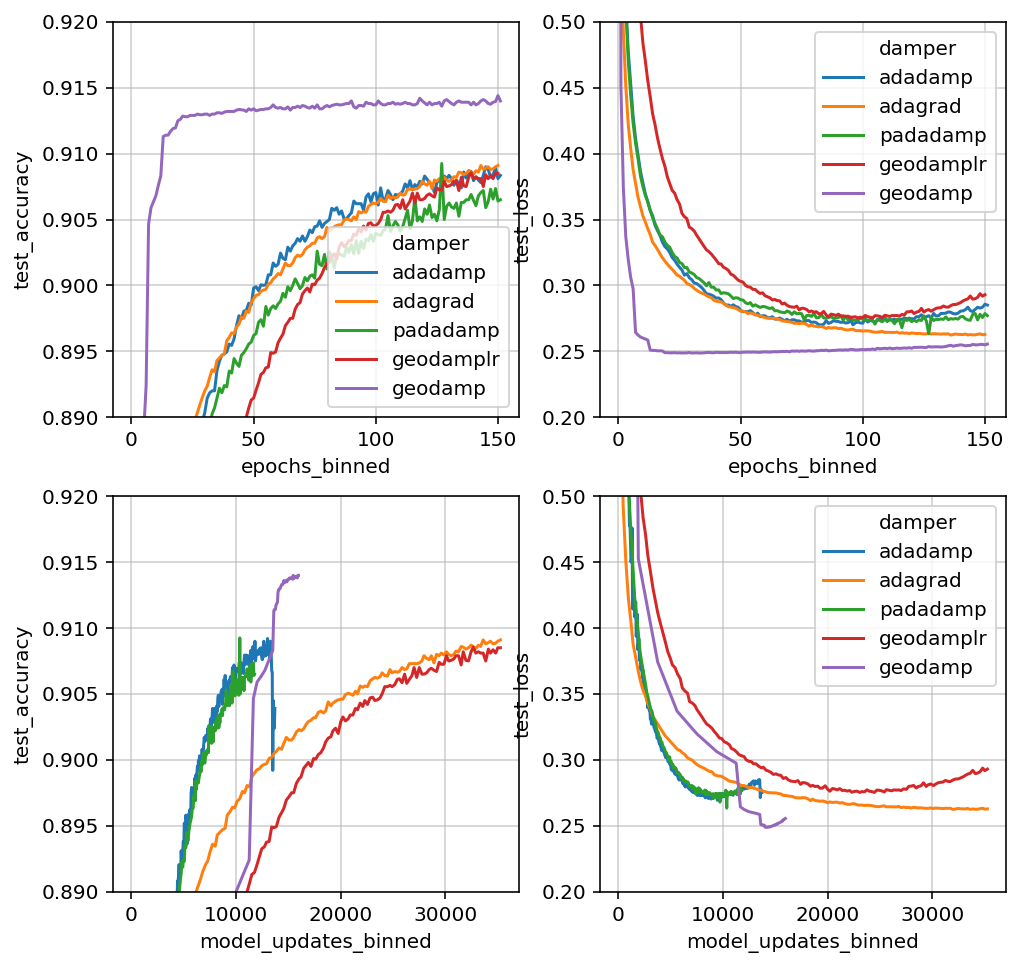

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
w = 8
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(w, w))

for i, x in enumerate(["epochs_binned", "model_updates_binned"]):
    for j, y in enumerate(["test_accuracy", "test_loss"]):
        idx = ~df.damper.isin([])
        show = df[idx].copy()
        show = show[show.epochs <= 150 + 1]
        ax = sns.lineplot(
            data=show,
            x=x,
            y=y,
            hue="damper",
            ax=axs[i][j],
            ci=None,
#             ci="sd",
#             ci=95,
            estimator=np.median,
        )
#         if "model" in x:
#             ax.set_xscale("log", basex=2)
#             ax.set_xlim(2**11, None)
        if "accuracy" in y:
            ax.set_ylim(0.89, 0.92)
        if "loss" in y:
            ax.set_ylim(0.2, 0.5)
        ax.grid(alpha=0.6)
        if "acc" in y and "model" in x:
            ax.legend_.remove()

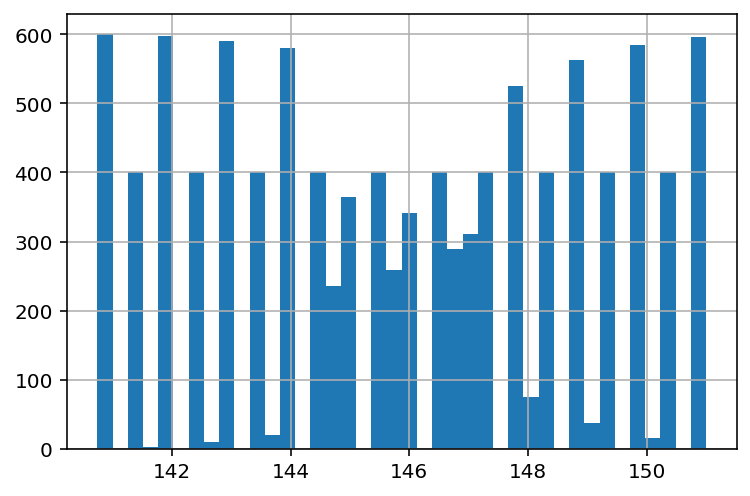

In [13]:
df[df.epochs_binned > 140].epochs.hist(bins=40)

In [14]:
DAMPERS = ["geodamp", "adagrad", "geodamplr", "adadamp"]
COLORS = ["C1", "C3", "C2", "C0"]
STYLES = [(0, (5, 1)), "-.", "--", "-"]

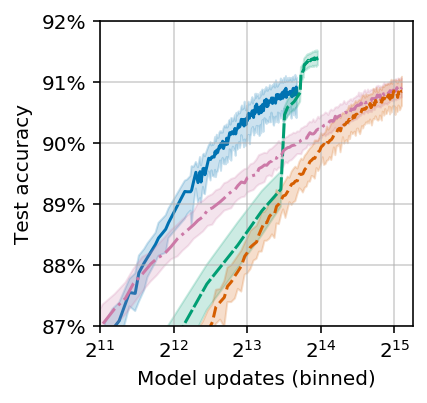

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("seaborn-colorblind")
w = 2.8
figsize = (w, w)
fig, ax = plt.subplots(figsize=figsize)

y = "test_accuracy"
x = "model_updates_binned"
for color, style, damper in zip(COLORS, STYLES, DAMPERS):
    if damper == "padadamp":
        continue
    idx = df.damper == damper
    show = df.loc[idx, [x, y, "epochs"]].copy()
    final_epoch = 150
    show = show[show.epochs <= final_epoch + 1]
    show["test_accuracy"] *= 100
    static = dict(index=x, values=y)
    middle = show.pivot_table(aggfunc="median", **static)[y]
    upper = show.pivot_table(aggfunc=lambda x: np.percentile(x, 75), **static)[y]
    lower = show.pivot_table(aggfunc=lambda x: np.percentile(x, 25), **static)[y]
    
    counts = show.pivot_table(aggfunc=len, **static)[y]
    counts = counts[counts >= 100]
    assert (counts.unique() >= 100).all()
    middle = middle.loc[counts.index]
    upper = upper.loc[counts.index]
    lower = lower.loc[counts.index]

    final_accs = show.loc[show.epochs >= final_epoch, ["test_accuracy"]]
    iqr_width = np.percentile(final_accs, 75) - np.percentile(final_accs, 25)
    acc_label = "{:0.2f} $\pm$ {:0.2f}".format(final_accs.median().item(), iqr_width / 2)
    
    d = damper.capitalize()
    if d.lower() == "geodamplr":
        d = "SGD"
    label = "{}\n({})".format(d, acc_label)

    kwargs = {}
    if damper == "adadamp":
        kwargs = {"zorder": -100}
    ax = middle.plot(color=color, linestyle=style, ax=ax, label=label, **kwargs)
    _ = ax.fill_between(upper.index, lower.values, upper.values, color=color, alpha=0.2, **kwargs)
    if "updates" in x:
        _ = ax.set_xscale("log", basex=2)
        _ = ax.set_xlim(2**11.0, 2**15.25)
        _ = ax.xaxis.set_major_locator(plt.FixedLocator([2**i for i in range(11, 16)]))
        
    if "accuracy" in y:
        _ = ax.set_ylim(87, 92)
    if "loss" in y:
        _ = ax.set_ylim(0.2, 0.5)
    _ = ax.grid(alpha=0.6)
    _ = ax.set_ylabel("Test accuracy")
    if "epoch" in x:
        _ = ax.set_xlabel("Epochs (binned)")
    elif "updates" in x:
        _ = ax.set_xlabel("Model updates (binned)")
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:0.0f}%'))
#     ax.legend(loc=(1.05, 0.23))
fig.savefig("figs/fmnist-updates.png", dpi=300, bbox_inches="tight")

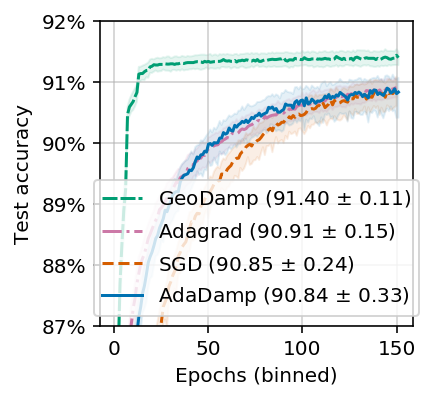

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
fig, ax = plt.subplots(figsize=figsize)

y = "test_accuracy"
x = "epochs_binned"
for color, style, damper in zip(COLORS, STYLES, DAMPERS):
    if damper == "padadamp":
        continue
    idx = df.damper == damper
    show = df.loc[idx, [x, y, "epochs"]].copy()
    show = show[show.epochs <= 150 + 1]
    show["test_accuracy"] *= 100
    static = dict(index=x, values=y)
    middle = show.pivot_table(aggfunc="median", **static)[y]
    upper = show.pivot_table(aggfunc=lambda x: np.percentile(x, 75), **static)[y]
    lower = show.pivot_table(aggfunc=lambda x: np.percentile(x, 25), **static)[y]

    counts = show.pivot_table(aggfunc=len, **static)[y]
    counts = counts[counts >= 100]
    assert (counts.unique() >= 100).all()
    middle = middle.loc[counts.index]
    upper = upper.loc[counts.index]
    lower = lower.loc[counts.index]

    final_accs = show.loc[show.epochs >= 150, ["test_accuracy"]]
    iqr_width = np.percentile(final_accs, 75) - np.percentile(final_accs, 25)
    acc_label = "{:0.2f} $\pm$ {:0.2f}".format(final_accs.median().item(), iqr_width / 2)
    d = damper.capitalize() if damper != "geodamplr" else "SGD"
    d = d.replace("damp", "Damp")
    label = "{} ({})".format(d, acc_label)
    
    kwargs = {}
#     if damper == "adadamp":
#         kwargs["zorder"] = -100
#     if damper == "agagrad":
#         kwargs["zorder"] = 10_000
#     elif damper == "geodamp":
#         kwargs["zorder"] = 0
    ax = middle.plot(color=color, linestyle=style, ax=ax, label=label, **kwargs)
    _ = ax.fill_between(upper.index, lower.values, upper.values, color=color, alpha=0.1, **kwargs)
    if "accuracy" in y:
        _ = ax.set_ylim(87, 92)
    if "loss" in y:
        _ = ax.set_ylim(0.2, 0.5)
    _ = ax.grid(alpha=0.6)
    _ = ax.set_ylabel("Test accuracy")
    if "epoch" in x:
        _ = ax.set_xlabel("Epochs (binned)")
    elif "updates" in x:
        _ = ax.set_xlabel("Model updates (binned)")
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:0.0f}%'))
#     _ = ax.legend(loc=(-1.35, 0.23))
#     _ = ax.legend(loc=(1.05, 0.23))
    ax.legend(loc="lower center")
fig.savefig("figs/fmnist-epochs.png", dpi=300, bbox_inches="tight")

In [17]:
lines = {}
for damper in DAMPERS:
    show = train_df[train_df.damper == damper]
    static = dict(index="model_updates", values="batch_size")
    middle = show.pivot_table(aggfunc="median", **static)
    lower = show.pivot_table(aggfunc=lambda x: np.percentile(x, 25), **static)
    upper = show.pivot_table(aggfunc=lambda x: np.percentile(x, 75), **static)

    counts = show.pivot_table(aggfunc=len, **static)["batch_size"]
    counts = counts[counts >= 100]
    assert (counts.unique() >= 100).all()
    middle = middle.loc[counts.index]
    upper = upper.loc[counts.index]
    lower = lower.loc[counts.index]

    lines[damper] = (lower, middle, upper)

geodamp
adagrad
geodamplr
adadamp


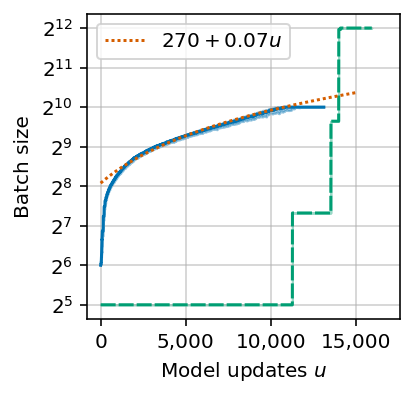

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=figsize)

for color, style, damper in zip(COLORS, STYLES, DAMPERS):
    print(damper)
    if damper in ["padadamp", "geodamplr", "adagrad"]:
        continue
    lower, middle, upper = lines[damper]
    assert lower.shape[1] == 1
    y1 = lower.values.flatten()
    y2 = upper.values.flatten()
    x = middle.index

    assert (middle.index == lower.index).all()
    assert (upper.index == lower.index).all()

    label = damper.capitalize()
    ax.plot(x, middle.values.flatten(), color, linestyle=style)#, label=label)
    ax.fill_between(x, y1, y2, alpha=0.4, color=color)

ax.set_yscale("log", basey=2)
ax.yaxis.set_major_locator(plt.FixedLocator([2**i for i in range(14)]))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
# ax.set_xscale("log", basex=2)
ax.set_xlim(None, 2**14.1)
ax.grid(alpha=0.6)
ax.set_ylabel("Batch size")
ax.set_xlabel("Model updates $u$")
u = np.arange(15e3)
b0, m = 270, 0.07
bs_hat = b0 + m*u
ax.plot(u, bs_hat, "C2", linestyle=(0, (1, 1)), label=f"${b0}+{m}u$")
ax.legend(loc="best")

fig.savefig("figs/fmnist-bs.png", dpi=300, bbox_inches="tight")

Text(0.5, 0, 'Model updates')

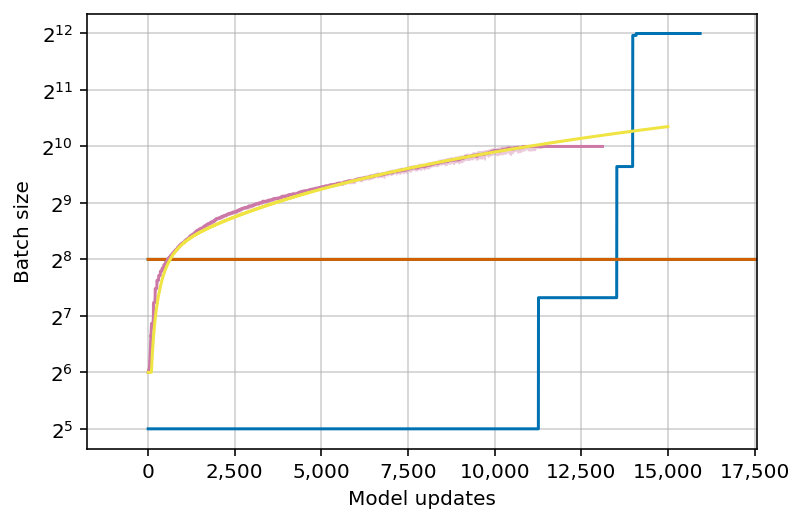

In [20]:

fig, ax = plt.subplots()
for damper in DAMPERS:
    if damper == "padadamp":
        continue
    lower, middle, upper = lines[damper]
    assert lower.shape[1] == 1
    y1 = lower.values.flatten()
    y2 = upper.values.flatten()
    x = middle.index

    assert (middle.index == lower.index).all()
    assert (upper.index == lower.index).all()

    label = damper.capitalize()
    ax.plot(x, middle.values.flatten(), label=label)
    ax.fill_between(x, y1, y2, alpha=0.4)
    

def get_bs(t, r, b0):
    bs = b0 + np.ceil(r * t)
    bs_hat = (1 - np.exp(-0.3e-2 * t)) * bs
    return max(b0 // 4, bs_hat)
    return bs

t = np.arange(1, 15000)
bs = [get_bs(_, 0.07, 256) for _ in t]
ax.plot(t, bs)

ax.set_yscale("log", basey=2)
ax.yaxis.set_major_locator(plt.FixedLocator([2**i for i in range(14)]))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
# ax.set_xscale("log", basex=2)
ax.set_xlim(None, 2**14.1)
ax.grid(alpha=0.6)
ax.set_ylabel("Batch size")
ax.set_xlabel("Model updates")

Text(0.5, 0, 'Model updates')

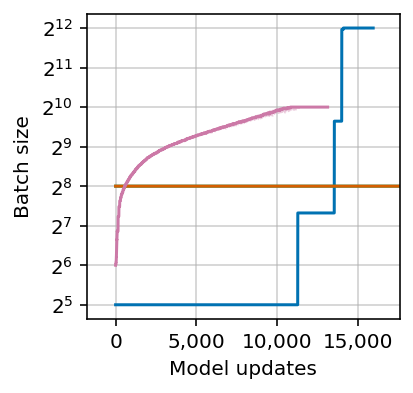

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=figsize)
for damper in DAMPERS:
    if damper == "padadamp":
        continue
    lower, middle, upper = lines[damper]
    assert lower.shape[1] == 1
    y1 = lower.values.flatten()
    y2 = upper.values.flatten()
    x = middle.index

    assert (middle.index == lower.index).all()
    assert (upper.index == lower.index).all()

    label = damper.capitalize()
    ax.plot(x, middle.values.flatten(), label=label)
    ax.fill_between(x, y1, y2, alpha=0.4)

ax.set_yscale("log", basey=2)
ax.yaxis.set_major_locator(plt.FixedLocator([2**i for i in range(14)]))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
# ax.set_xscale("log", basex=2)
ax.set_xlim(None, 2**14.1)
ax.grid(alpha=0.6)
ax.set_ylabel("Batch size")
ax.set_xlabel("Model updates")

# fig.savefig("figs/fmnist-bs.png", dpi=300, bbox_inches="tight")